In [3]:
library('biom')
library('vegan')
library('DESeq2')
library('rafalib')

library(ggbiplot)
library(ggplot2)
library(RColorBrewer)
library(stringr)
library(reshape2)
library(phyloseq)
suppressMessages(library(vegan))
suppressMessages(library(DESeq2))
suppressMessages(library(gplots))
options(width=110)
library(ggvegan)



## 1.  weighted unifrac PCoA

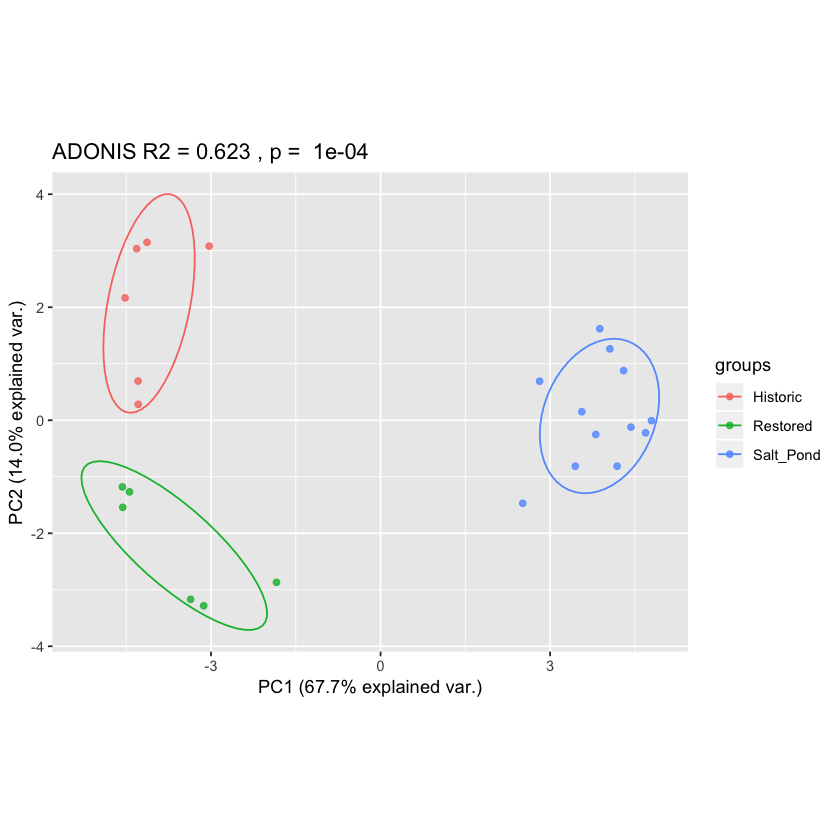

In [4]:
# 菌群数据实战
# 读入实验设计
design = read.table("/Users/jzz0026/Google_superjohnlove/jupyter/Salt_pond_v2/itag_analysis/map2.txt", header=F, row.names= 1, sep="\t") 

# 读取OTU表
otu_table = read.delim("/Users/jzz0026/Google_superjohnlove/jupyter/Salt_pond_v2/itag_analysis/itag_analysis_v2/beta/weighted_unifrac_Salt_pond_16S_otu.tax.filtered.txt", row.names= 1,  header=T, sep="\t")

# 过滤数据并排序
idx = rownames(design) %in% colnames(otu_table) 
sub_design = design[idx,]
count = otu_table[rownames(sub_design), rownames(sub_design)]

# 基于OTU表PCA分析
otu.pca <- prcomp(t(count), scale. = TRUE)

# R2 ADONIS
adonis_r <- adonis(count  ~ sub_design$V4, permutations=9999)
R2 <- round(adonis_r$aov.tab$R2[1], digits=3)


# 绘制PCA图，并按组添加椭圆
ggbiplot(otu.pca, obs.scale = 1, var.scale = 1,
         groups = sub_design$V4, ellipse = TRUE,var.axes = F,alpha = 0.8) + ggtitle(paste("ADONIS R2 =", R2, ", p = ",adonis_r$aov.tab$Pr[1]))


#colnames(OTU_d)
#sub_design$V4
#otu.pca

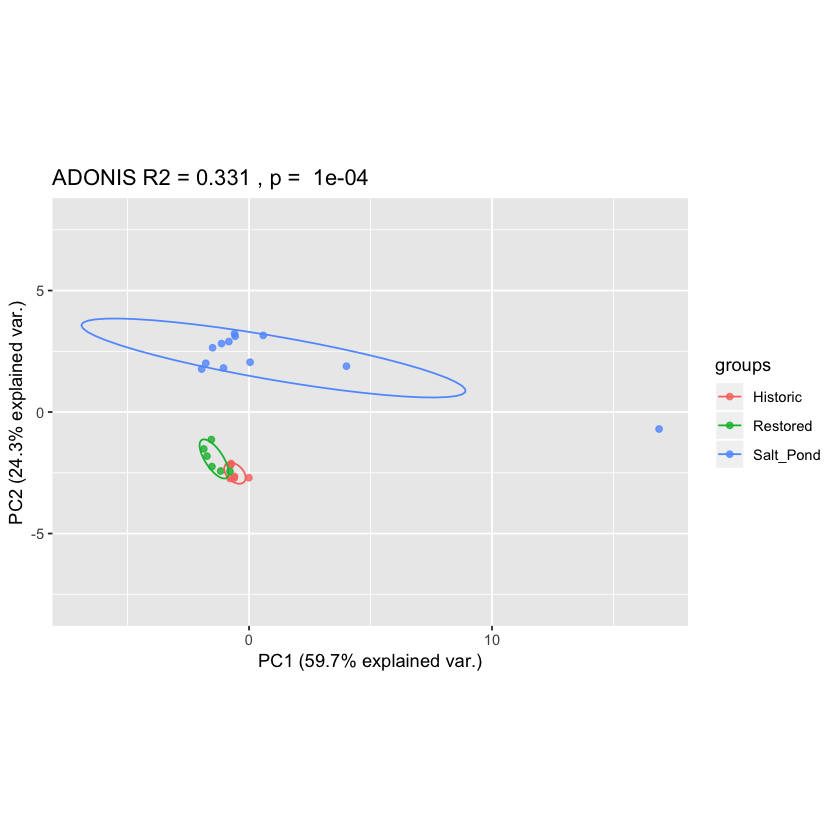

In [5]:
gene_table = read.delim("/Users/jzz0026/Documents/GitHub/SaltBayPond/Salt_pond_KO_ordered_DESeq2.txt", row.names= 1,  header=T, sep="\t")

d.bray <- vegdist(t(gene_table))
d.bray <- data.matrix(d.bray)
d.bray <- d.bray[rownames(sub_design), rownames(sub_design)]

# R2 ADONIS
adonis_r <- adonis(d.bray  ~ sub_design$V4, permutations=9999)
R2 <- round(adonis_r$aov.tab$R2[1], digits=3)

gene.pca <- prcomp(d.bray, scale. = TRUE)



ggbiplot(gene.pca, obs.scale = 1, var.scale = 1,
         groups = sub_design$V4, ellipse = TRUE,var.axes = F,alpha = 0.8) + ggtitle(paste("ADONIS R2 =", R2, ", p = ",adonis_r$aov.tab$Pr[1])) + ylim(-8, 8)


In [6]:
# load biom file
OTU.biom <- read_biom("/Users/jzz0026/Google_superjohnlove/jupyter/Salt_pond_v2/itag_analysis/itag_analysis_v2/Salt_pond_16S_otu.tax.filtered.biom") #'OTU_table.biom'

# Extract data matrix (OTU counts) from biom table
OTU <- as.matrix(biom_data(OTU.biom))
otus <- t(OTU)
otus <- sweep(otus, 1, rowSums(otus),'/')

env.data <- read.csv("/Users/jzz0026/Google_superjohnlove/jupyter/Saltpond/Wyatt_C-P_CH402/Salt_pond_ALL_Meta_whh.txt", row.names = 1, fill = T, header=T, sep="\t")
rownames(env.data) = env.data$Sample
env.data2 = env.data[c("Salinity","Cl","NP_ext","CH4_pos_lin")]

##by log
env.data.log <- log1p(env.data2)##
##delete NA
env <- na.omit(env.data.log)

# find the overlapping samples
common.ids <- intersect(rownames(env), rownames(otus))

# get just the overlapping samples
otus <- otus[common.ids,]
map <- env[common.ids,]

# Keep only OTUs present in at least 50% of samples
# This is fairly aggressive but will reduce the clutter in biplots
otus <- otus[,colMeans(otus>0)>.5]


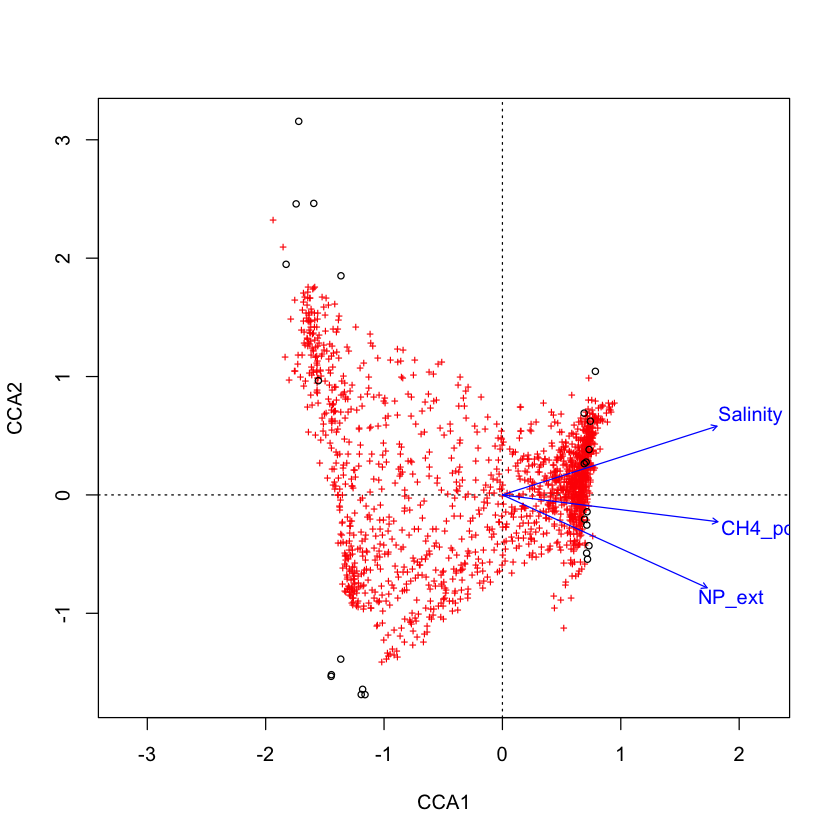

In [7]:
# run CA using vegan command
my.cca <- cca(otus ~ Salinity + NP_ext + CH4_pos_lin, data=map)
#my.cca
plot(my.cca)

In [8]:
my.cca

Call: cca(formula = otus ~ Salinity + NP_ext + CH4_pos_lin, data = map)

              Inertia Proportion Rank
Total          3.8070     1.0000     
Constrained    1.3814     0.3629    3
Unconstrained  2.4256     0.6371   20
Inertia is scaled Chi-square 

Eigenvalues for constrained axes:
  CCA1   CCA2   CCA3 
0.8518 0.3633 0.1663 

Eigenvalues for unconstrained axes:
   CA1    CA2    CA3    CA4    CA5    CA6    CA7    CA8 
0.4523 0.3801 0.2595 0.2442 0.2024 0.1481 0.1304 0.1060 
(Showed only 8 of all 20 unconstrained eigenvalues)


## PCoA distance method "bray"

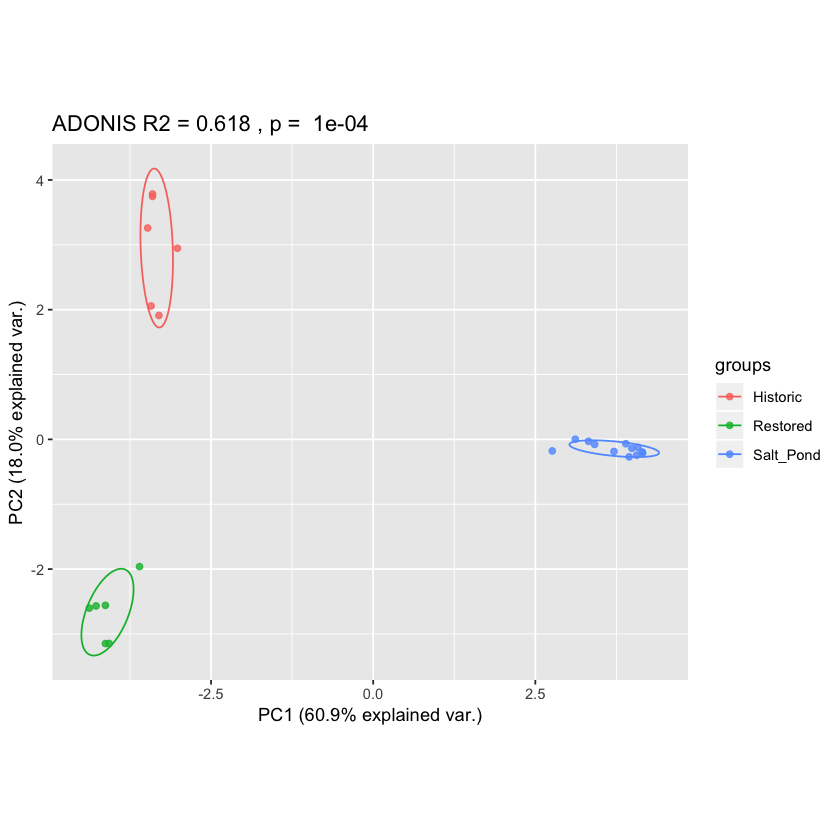

In [11]:
OTU.biom <- read_biom("/Users/jzz0026/Google_superjohnlove/jupyter/Salt_pond_v2/itag_analysis/itag_analysis_v2/Salt_pond_16S_otu.tax.filtered.biom") #'OTU_table.biom'

# Extract data matrix (OTU counts) from biom table
OTU <- as.matrix(biom_data(OTU.biom))
    
# transpose so that rows are samples and columns are genera
OTU <- t(OTU)
OTU_d <- vegdist(OTU, method="bray", diag=TRUE, upper=TRUE)
OTU_d <- as.matrix(OTU_d)
OTU_d <- OTU_d[rownames(sub_design), rownames(sub_design)]

# 基于OTU表PCA分析
otu.pca <- prcomp(OTU_d, scale. = TRUE)


# R2 ADONIS
adonis_r <- adonis(OTU_d  ~ sub_design$V4, permutations=9999, method="bray")
R2 <- round(adonis_r$aov.tab$R2[1], digits=3)

# 绘制PCA图，并按组添加椭圆
ggbiplot(otu.pca, obs.scale = 1, var.scale = 1,
         groups = sub_design$V4, ellipse = TRUE,var.axes = F,alpha = 0.8) + ggtitle(paste("ADONIS R2 =", R2, ", p = ",adonis_r$aov.tab$Pr[1]))
#rownames(OTU_d)
#sub_design$V4


## 2.  Unweighted unifrac PCoA

In [ ]:
# 菌群数据实战
# 读入实验设计
design = read.table("/Users/jzz0026/Google_superjohnlove/jupyter/Salt_pond_v2/itag_analysis/map2.txt", header=F, row.names= 1, sep="\t") 

# 读取OTU表
otu_table = read.delim("/Users/jzz0026/Google_superjohnlove/jupyter/Salt_pond_v2/itag_analysis/itag_analysis_v2/beta/unweighted_unifrac_Salt_pond_16S_otu.tax.filtered.txt", row.names= 1,  header=T, sep="\t")

# 过滤数据并排序
idx = rownames(design) %in% colnames(otu_table) 
sub_design = design[idx,]
count = otu_table[rownames(sub_design), rownames(sub_design)]

# 基于OTU表PCA分析
otu.pca <- prcomp(t(count), scale. = TRUE)

# R2 ADONIS
adonis_r <- adonis(count  ~ sub_design$V4, permutations=999, method="bray")
R2 <- round(adonis_r$aov.tab$R2[1], digits=3)

# 绘制PCA图，并按组添加椭圆
ggbiplot(otu.pca, obs.scale = 1, var.scale = 1,
         groups = sub_design$V4, ellipse = TRUE,var.axes = F) + ggtitle(paste("ADONIS R2 =", R2))